# Extending linear models

## Imports

In [14]:
%config InlineBackend.figure_format="retina"

In [162]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from pandas import DataFrame
from scipy import stats
from tensorflow_probability import distributions as tfd

## Transforming covariates

Can transform covariates—$\mathbf{X}$—to
make relationship between $\mathbf{X}$ and $Y$ nonlinear—such
as taking the square root
or log.

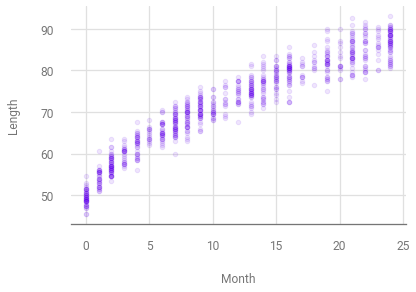

In [10]:
babies = pd.read_csv(
    "https://raw.githubusercontent.com"
    "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
    "/data/babies.csv"
).assign(Intercept=1)
babies.plot.scatter(x="Month", y="Length", alpha=0.1);

In [13]:
with pm.Model() as model_baby_linear:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", pm.math.dot(babies[["Intercept", "Month"]], β))
    ϵ = pm.HalfNormal("ϵ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=ϵ, observed=babies["Length"])

    trace_linear = pm.sample(draws=2_000, tune=4_000)
    pcc_linear = pm.sample_posterior_predictive(trace_linear)
    inf_data_linear = az.from_pymc3(trace=trace_linear, posterior_predictive=pcc_linear)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 38 seconds.


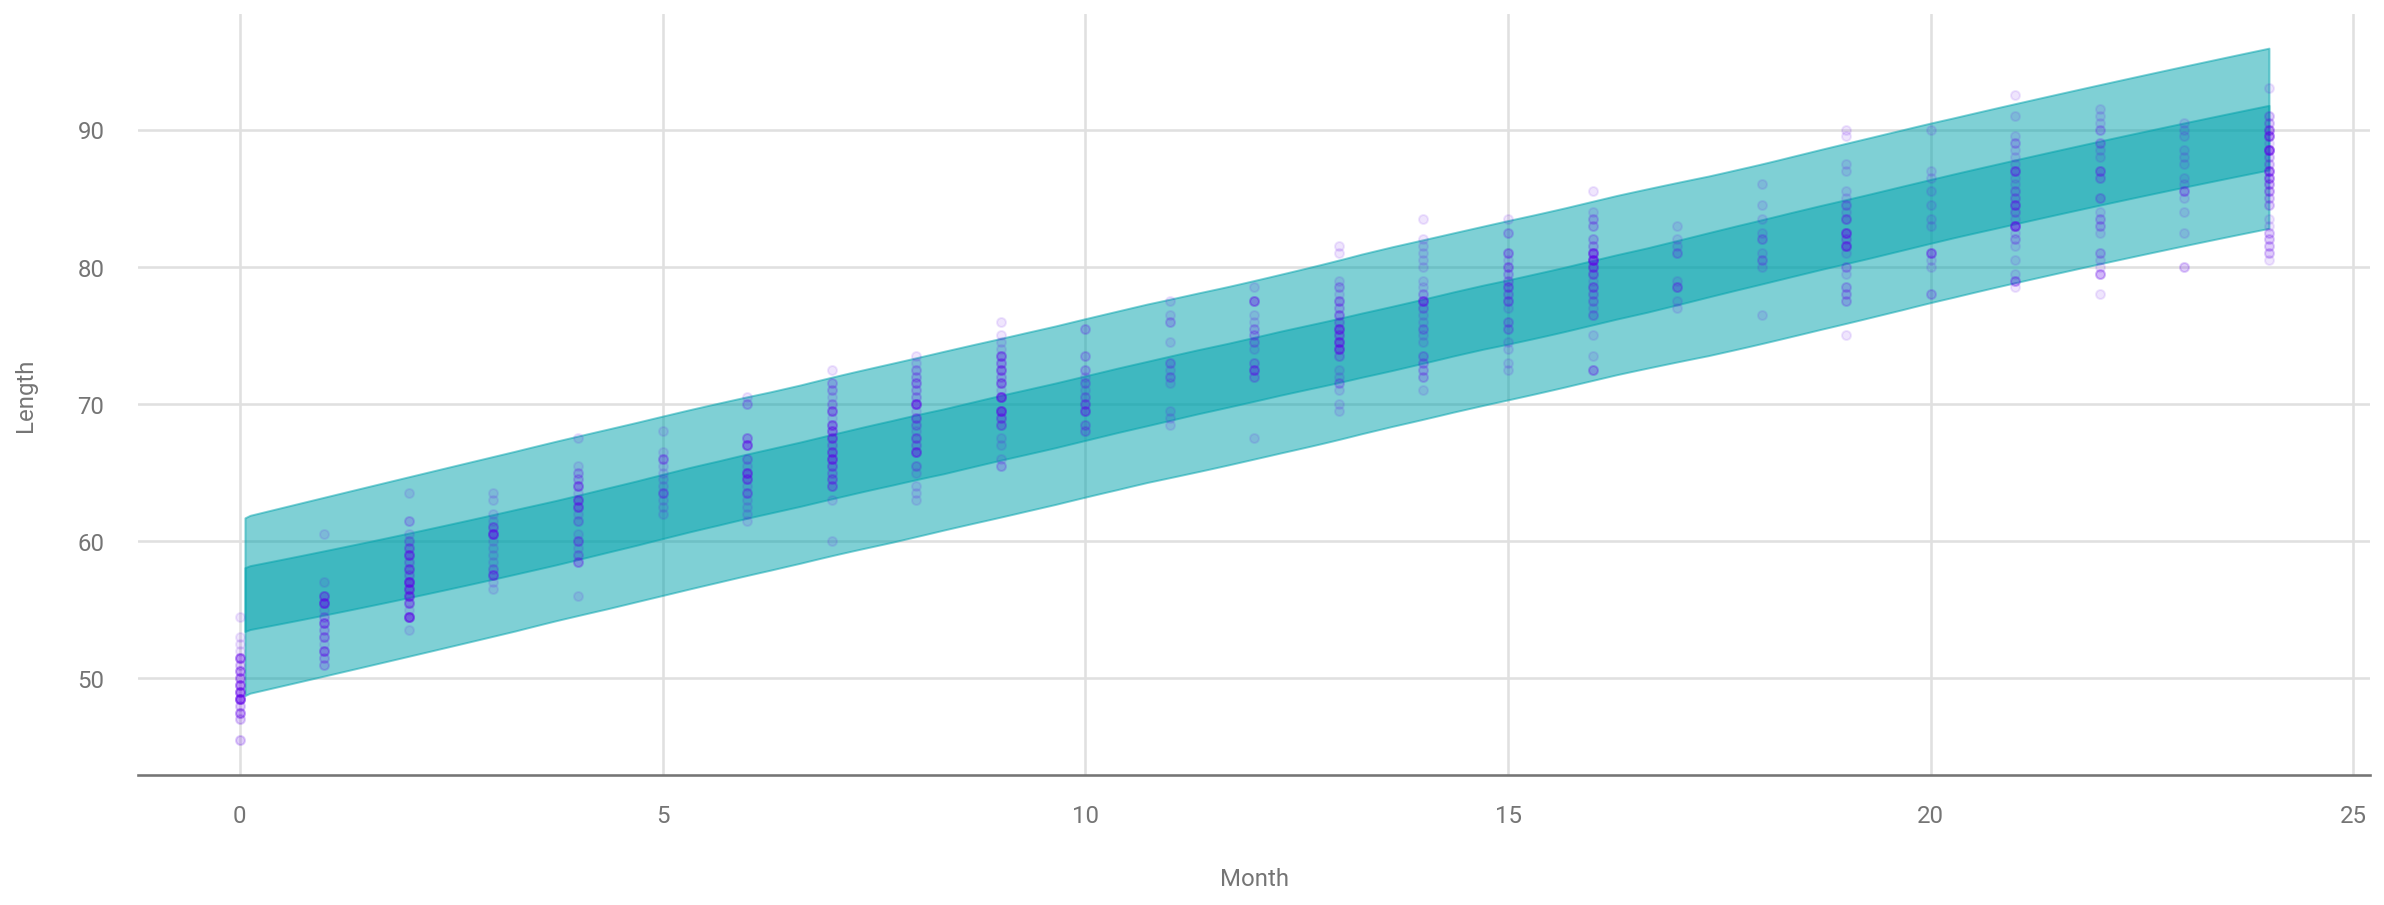

In [18]:
_, ax = plt.subplots(figsize=(20, 7))

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_linear["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax,
    )
babies.plot.scatter(x="Month", y="Length", alpha=0.1, ax=ax);

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8942696754162789, but should be close to 0.8. Try to increase the number of tuning steps.


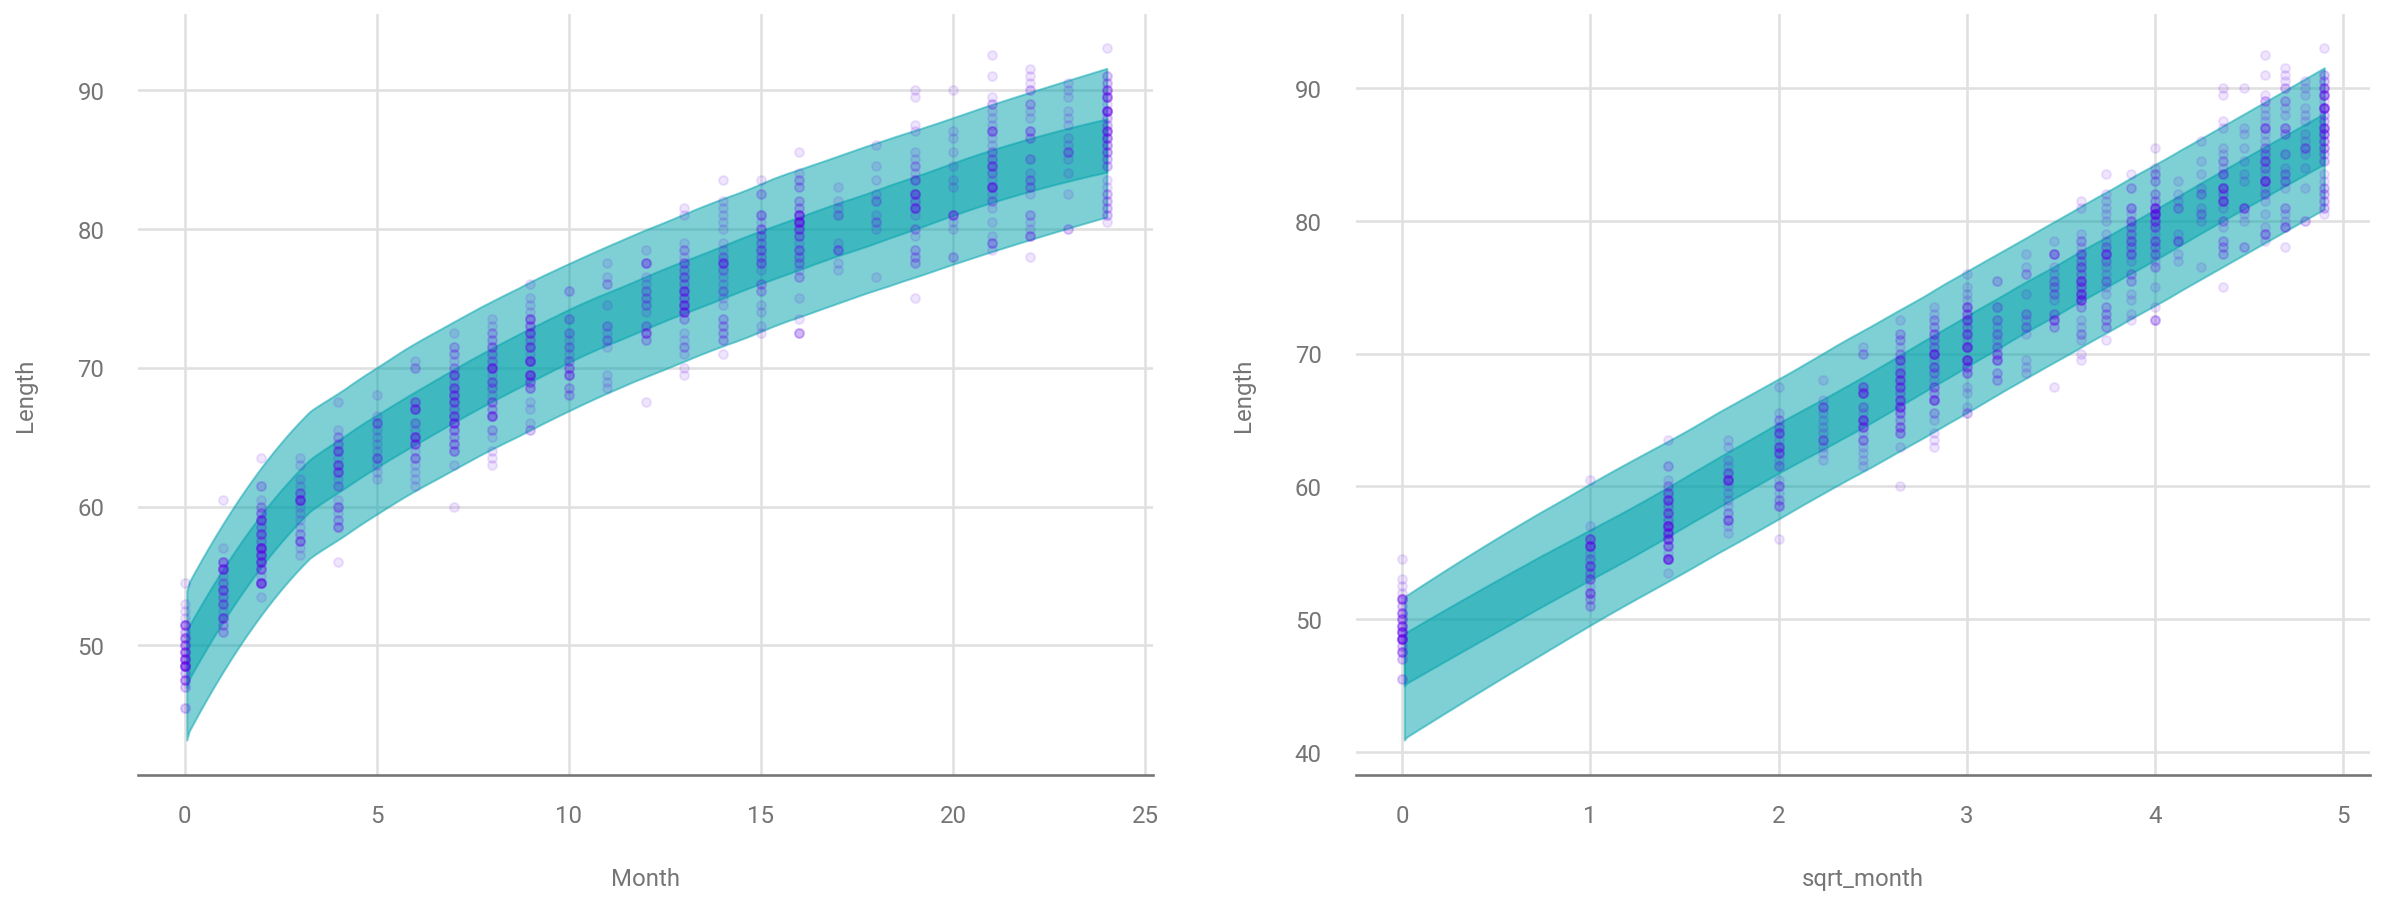

In [28]:
with pm.Model() as model_baby_sqrt:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.HalfNormal("σ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])

    inf_data_sqrt = pm.sample(draws=2000, tune=4000)
    ppc_baby_sqrt = pm.sample_posterior_predictive(inf_data_sqrt)
    inf_data_sqrt = az.from_pymc3(
        trace=inf_data_sqrt, posterior_predictive=ppc_baby_sqrt
    )

_, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(20, 7))

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_sqrt["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax_left,
    )
babies.plot.scatter(x="Month", y="Length", alpha=0.1, ax=ax_left)
for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        np.sqrt(babies["Month"]),
        inf_data_sqrt["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax_right,
    )
(
    babies.assign(sqrt_month=lambda df: np.sqrt(df["Month"])).plot.scatter(
        x="sqrt_month", y="Length", alpha=0.1, ax=ax_right
    )
);

## Varying uncertainty

Before we assumed variance is constant
thourought the range.
But we can also make it variable:

$$
\begin{split}
    \mu =& \beta_0 + \beta_1 f_1(X_1) + \dots + \beta_m f_m(X_m) \\
    \sigma =& \delta_0 + \delta_1 g_1(X_1) + \dots + \delta_m g_m(X_m) \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


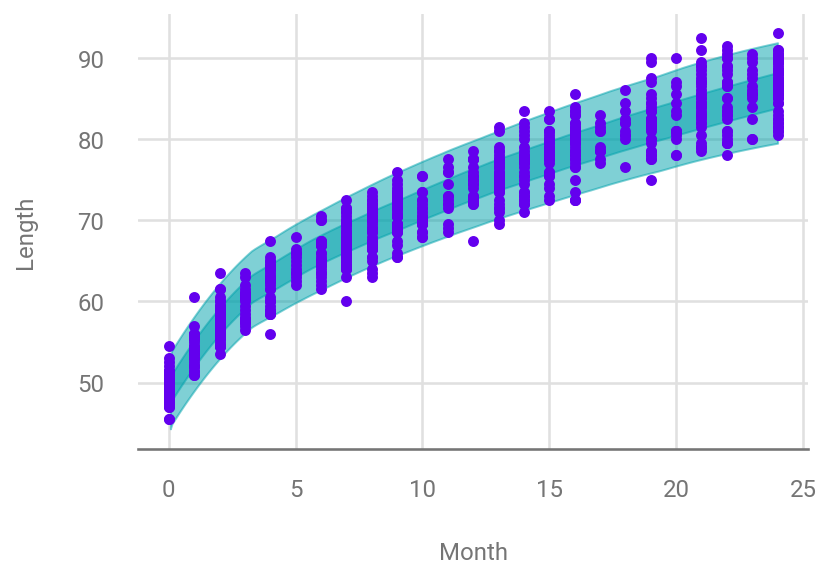

In [31]:
with pm.Model() as model_baby_vv:
    β = pm.Normal("β", sigma=10, shape=2)

    δ = pm.HalfNormal("δ", sigma=10, shape=2)
    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.Deterministic("σ", δ[0] + δ[1] * babies["Month"])

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])

    trace_baby_vv = pm.sample(2000, target_accept=0.95)
    ppc_baby_vv = pm.sample_posterior_predictive(
        trace_baby_vv, var_names=["length", "σ"]
    )
    inf_data_baby_vv = az.from_pymc3(
        trace=trace_baby_vv, posterior_predictive=ppc_baby_vv
    )

_, ax = plt.subplots()
for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_baby_vv.posterior_predictive["length"],
        hdi_prob=hdi_prob,
        ax=ax,
    )
babies.plot.scatter(x="Month", y="Length", ax=ax);

## Interaction effects

Covariates are not always independent.

$$
\begin{split}
    \mu =& \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1X_2\\
    Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

In [34]:
tips_df = pd.read_csv(
    "https://raw.githubusercontent.com"
    "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
    "/data/tips.csv"
)
tips = tips_df["tip"]
total_bill_c = tips_df["total_bill"] - tips_df["total_bill"].mean()  # Center bill
smoker = pd.Categorical(tips_df["smoker"]).codes

with pm.Model() as model_no_interactions:
    β = pm.Normal("β", mu=0, sigma=1, shape=3)
    σ = pm.HalfNormal("σ", 1)

    μ = β[1] + β[1] * total_bill_c + β[2] * smoker

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_no_interaction = pm.sample(1_000, tune=1_000)

with pm.Model() as model_interaction:
    β = pm.Normal("β", mu=0, sigma=1, shape=4)
    σ = pm.HalfNormal("σ", 1)

    μ = β[0] + β[1] * total_bill_c + β[2] * smoker + β[3] * smoker * total_bill_c

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_interaction = pm.sample(1000, tune=1000)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


![Smoker Tip Interaction](images/chapter_4/Smoker_Tip_Interaction.png)


## Robust regression

For outliers,
can remove them with some criteria—like
3 standard deviations of 1.5 times the interquartile range—
or make model that can handle outliers—like
Student's t-distribution.

Degrees of freedom—$\nu$—for
Student's t controls the weight of the tails.
When $\nu$ is small
there is more distribution in the tails.

In [40]:
def generate_sales(*, days: int, mean: float, std: float, label: str) -> DataFrame:
    """Create dataset representing sales."""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days + 1), columns=["customers", "sales"])
    for day in range(1, days + 1):
        num_customers = stats.randint(30, 100).rvs() + 1

        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()

        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales

    # Fix the types as not to cause Theano errors
    df = df.astype({"customers": "int32", "sales": "float32"})

    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

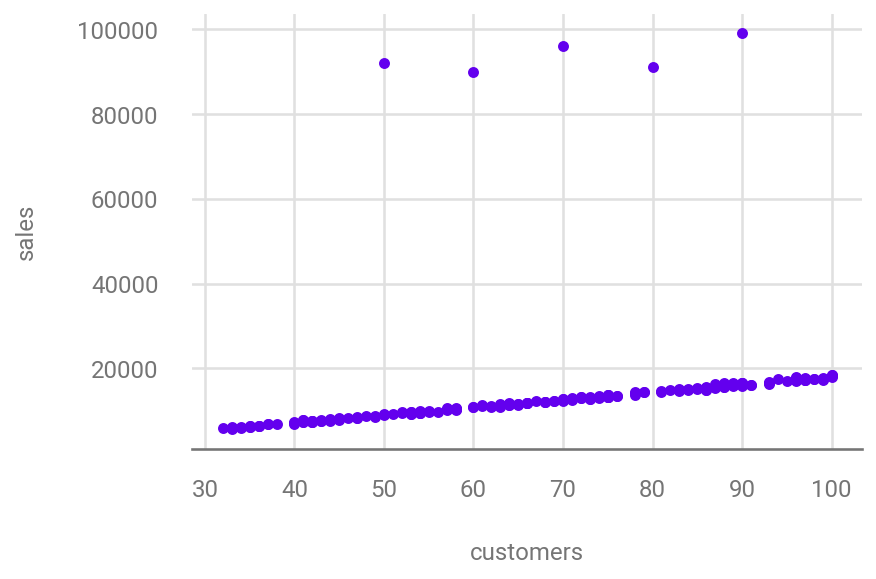

In [42]:
empanadas = generate_sales(days=200, mean=180, std=30, label="Empanada")
empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]
empanadas = empanadas.sort_values("customers")

empanadas.plot.scatter(x="customers", y="sales");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8860777877942666, but should be close to 0.8. Try to increase the number of tuning steps.


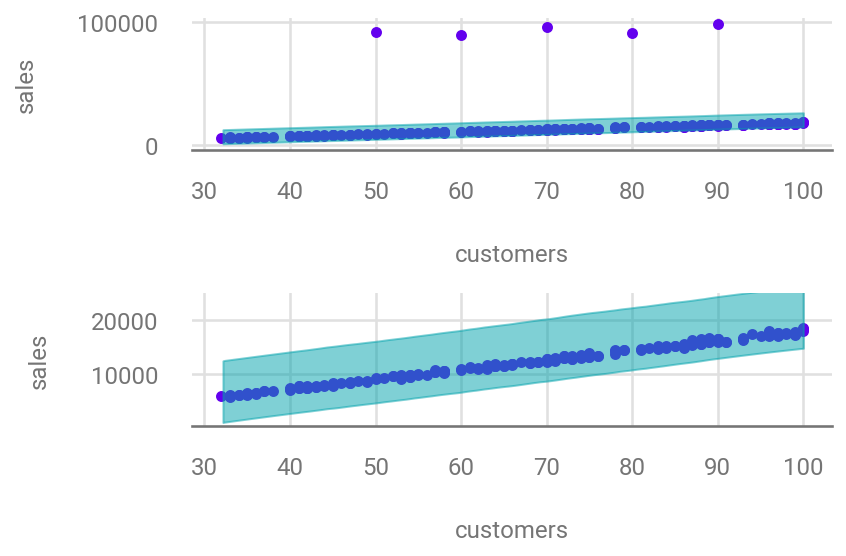

In [50]:
with pm.Model() as model_non_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal("β", mu=150, sigma=20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])

    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=empanadas["sales"])

    trace_empanada_sales = pm.sample(random_seed=1, return_inferencedata=False)
    ppc_empanada_sales = pm.sample_posterior_predictive(trace_empanada_sales)
    inf_data_non_robust = az.from_pymc3(
        trace=trace_empanada_sales, posterior_predictive=ppc_empanada_sales
    )

_, (top_ax, bottom_ax) = plt.subplots(2)

for ax in [top_ax, bottom_ax]:
    empanadas.plot.scatter(x="customers", y="sales", ax=ax)
    az.plot_hdi(
        empanadas["customers"],
        inf_data_non_robust.posterior_predictive["sales"],
        hdi_prob=0.95,
        ax=ax,
    )

bottom_ax.set_ylim(400, 25000)
plt.tight_layout();

In [49]:
az.summary(inf_data_non_robust, kind="stats", var_names=["β", "σ"])

,mean,sd,hdi_3%,hdi_97%
β,207.024,2.998,201.351,212.454
σ,2952.283,25.259,2904.297,2997.569


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


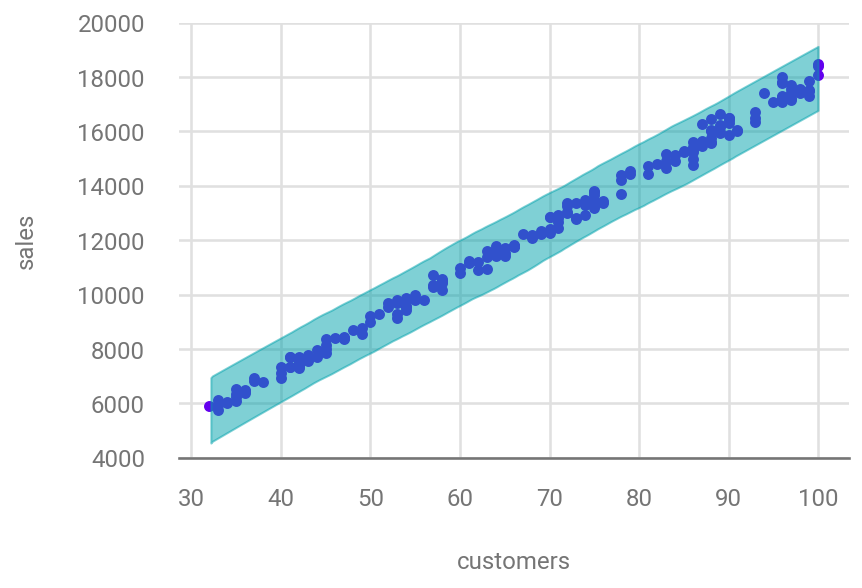

In [51]:
with pm.Model() as model_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal("β", mu=150, sigma=20)
    ν = pm.HalfNormal("ν", 20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])

    sales = pm.StudentT("sales", mu=μ, sigma=σ, nu=ν, observed=empanadas["sales"])

    trace_empanada_sales_robust = pm.sample(random_seed=0, return_inferencedata=False)
    ppc_empanada_sales_robust = pm.sample_posterior_predictive(
        trace_empanada_sales_robust
    )

    inf_data_robust = az.from_pymc3(
        trace=trace_empanada_sales_robust,
        posterior_predictive=ppc_empanada_sales_robust,
    )

_, ax = plt.subplots()

empanadas.plot.scatter(x="customers", y="sales", ax=ax)
(
    az.plot_hdi(
        empanadas["customers"],
        inf_data_robust.posterior_predictive["sales"],
        hdi_prob=0.95,
        ax=ax,
    ).set(ylim=(4_000, 20_000))
);

In [52]:
az.summary(inf_data_robust, var_names=["β", "σ", "ν"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
β,179.605,0.261,179.111,180.076
σ,151.989,13.942,126.355,178.442
ν,1.287,0.167,0.989,1.601


Big reduction in $\sigma$ in Student-t model

## Pooling, multilevel models, and mixed effects

Some dataset contain additional nested structures—resulting
in some heirarchical data groups.

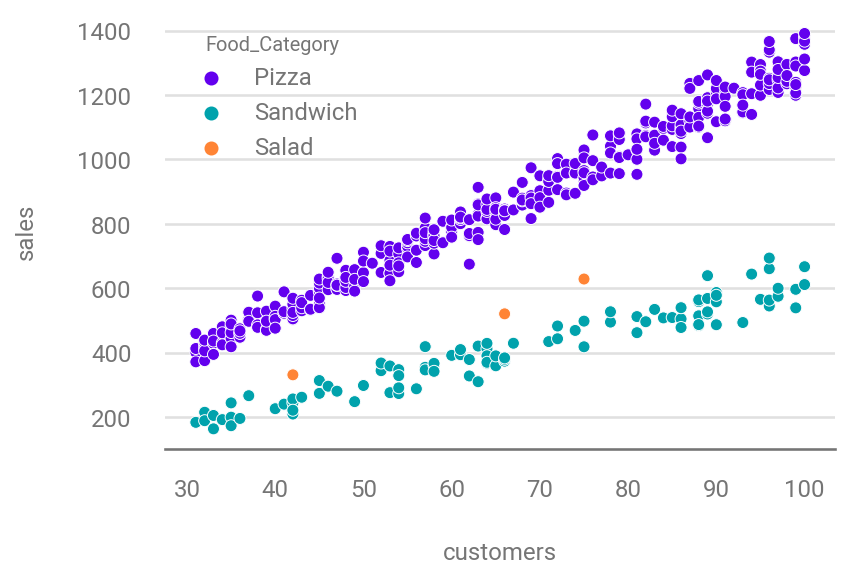

In [58]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")
salad_df = generate_sales(days=3, mean=8, std=3, label="Salad")
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)

sales_df.pipe((sns.scatterplot, "data"), x="customers", y="sales", hue="Food_Category");

### Unpooled parameters

In [73]:
customers = sales_df.loc[:, "customers"].to_numpy()
sales_observed = sales_df.loc[:, "sales"].to_numpy()
food_category = pd.Categorical(sales_df["Food_Category"])

with pm.Model(
    coords={"food_category": food_category.categories}
) as model_sales_unpooled:
    σ = pm.HalfNormal("σ", sigma=20, dims="food_category")
    β = pm.Normal("β", mu=10, sigma=10, dims="food_category")
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)
    sales = pm.Normal(
        "sales", mu=μ, sigma=σ[food_category.codes], observed=sales_observed
    )
    trace_sales_unpooled = pm.sample(target_accept=0.9, return_inferencedata=False)
    inf_data_sales_unpooled = az.from_pymc3(trace=trace_sales_unpooled)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


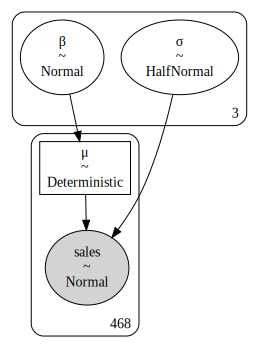

In [139]:
pm.model_to_graphviz(model_sales_unpooled)

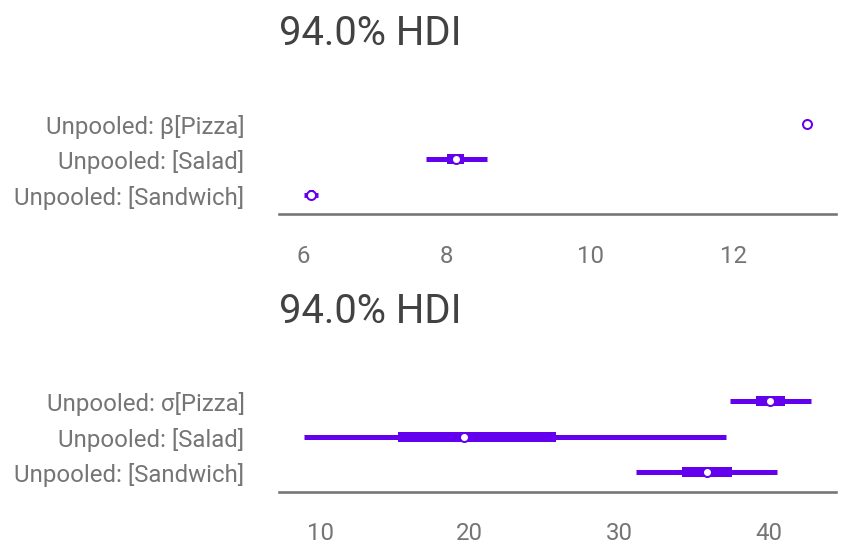

In [70]:
_, axes = plt.subplots(2)
for var_name, ax in zip(["β", "σ"], axes):
    az.plot_forest(
        [inf_data_sales_unpooled],
        model_names=["Unpooled"],
        var_names=[var_name],
        combined=True,
        ax=ax,
    )
plt.tight_layout();

$\beta$ is widest for salad,
and $\sigma$ is vary wide for salad.
Result is identical to creating three seperate models
with subsets of the data.

### Pooled parameters

In [76]:
with pm.Model() as model_sales_pooled:
    σ = pm.HalfNormal("σ", sigma=20)
    β = pm.Normal("β", mu=10, sigma=10)

    μ = pm.Deterministic("μ", var=β * customers)

    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=sales_observed)

    trace_data_sales_pooled = pm.sample(return_inferencedata=False)
    ppc_sales_pooled = pm.sample_posterior_predictive(trace_data_sales_pooled)
    inf_data_sales_pooled = az.from_pymc3(
        trace=trace_data_sales_pooled,
        posterior_predictive=ppc_sales_pooled,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


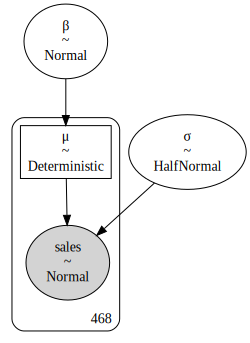

In [138]:
pm.model_to_graphviz(model_sales_pooled)

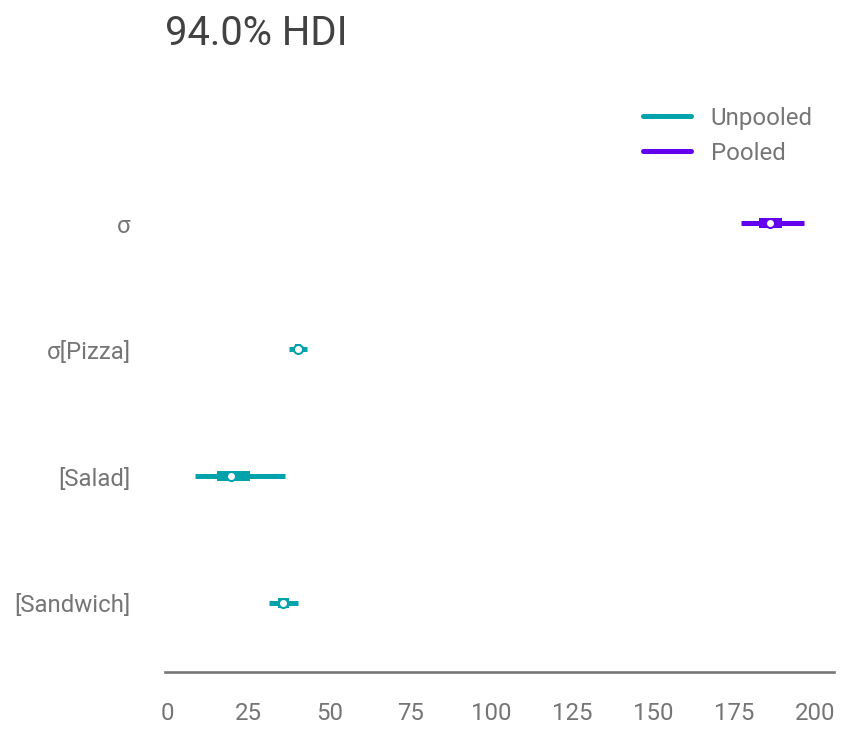

In [80]:
az.plot_forest(
    [inf_data_sales_pooled, inf_data_sales_unpooled],
    model_names=["Pooled", "Unpooled"],
    var_names=["σ"],
    combined=True,
);

Pooled means more data for each parameter,
but we don't understand each group individually.

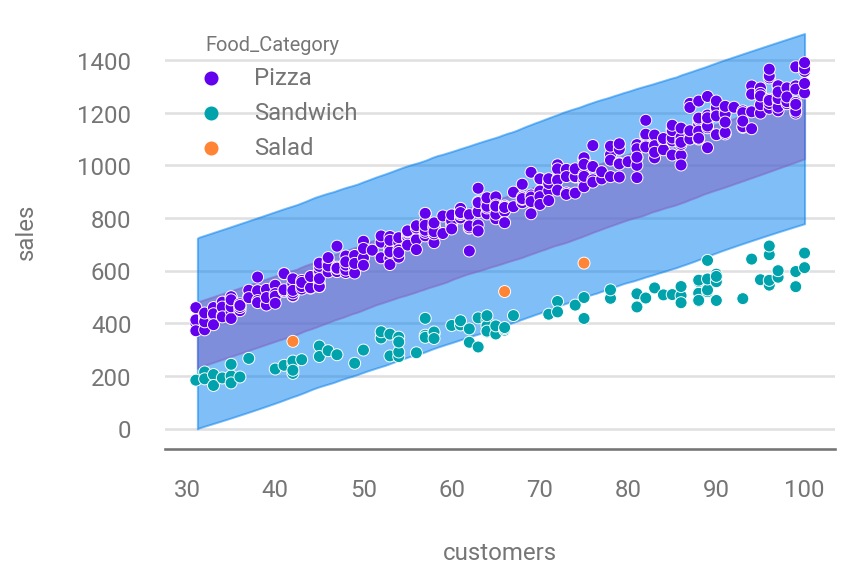

In [84]:
_, ax = plt.subplots()

for i, hdi_prob in enumerate([0.50, 0.95]):
    az.plot_hdi(
        customers,
        inf_data_sales_pooled["posterior_predictive"]["sales"],
        hdi_prob=hdi_prob,
        ax=ax,
        color=f"C{i + 3}",
    )
sales_df.pipe(
    (sns.scatterplot, "data"),
    x="customers",
    y="sales",
    hue="Food_Category",
    ax=ax,
);

### Mixing group and common parameters

Can pool only some parameters instead.

In [85]:
with pm.Model(
    coords={"food_category": food_category.categories}
) as model_pooled_sigma_sales:
    σ = pm.HalfNormal("σ", sigma=20)
    β = pm.Normal("β", mu=10, sigma=20, dims="food_category")

    μ = pm.Deterministic("μ", var=β[food_category.codes] * customers)
    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=sales_observed)

    trace_pooled_sigma_sales = pm.sample(return_inferencedata=False)
    ppc_pooled_sigma_sales = pm.sample_posterior_predictive(trace_pooled_sigma_sales)

    inf_data_pooled_sigma_sales = az.from_pymc3(
        trace=trace_pooled_sigma_sales,
        posterior_predictive=ppc_pooled_sigma_sales,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


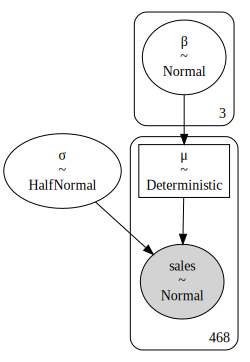

In [137]:
pm.model_to_graphviz(model_pooled_sigma_sales)

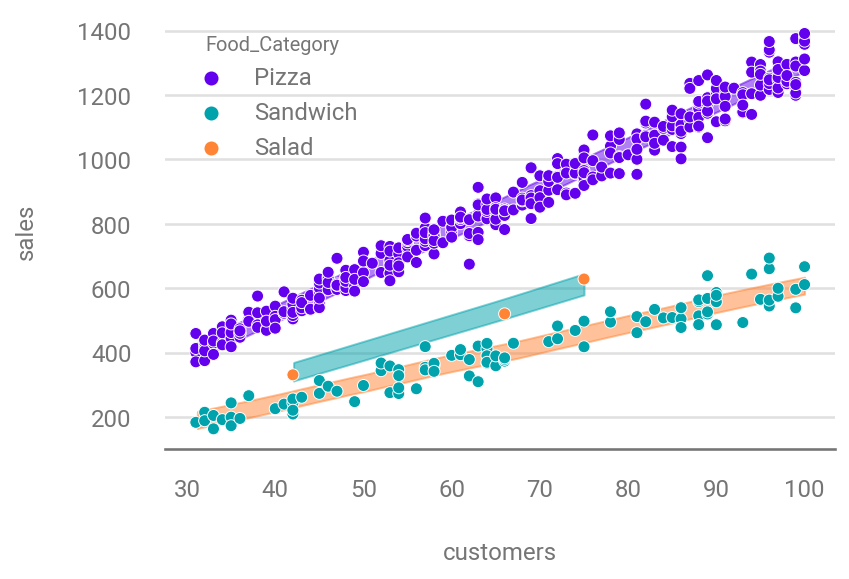

In [131]:
_, ax = plt.subplots()
for idx, food in enumerate(food_category.categories):
    food_category_mask = sales_df["Food_Category"] == food
    az.plot_hdi(
        sales_df["customers"][food_category_mask],
        inf_data_pooled_sigma_sales["posterior_predictive"]["sales"][
            :, :, food_category_mask
        ],
        hdi_prob=0.5,
        ax=ax,
        color=f"C{idx}",
    )

sales_df.pipe(
    (sns.scatterplot, "data"),
    x="customers",
    y="sales",
    hue="Food_Category",
    ax=ax,
);

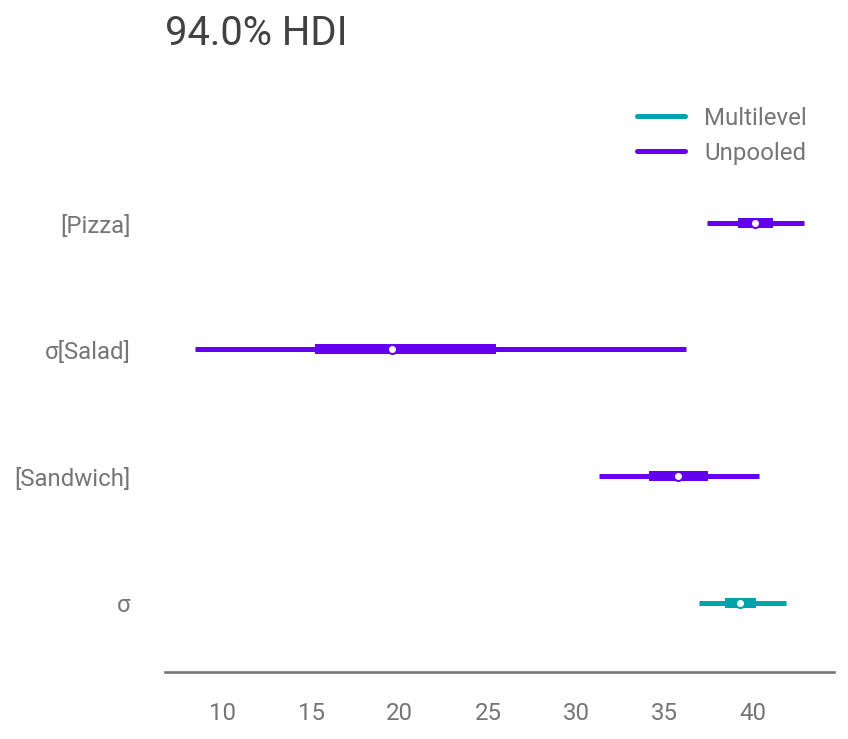

In [134]:
az.plot_forest(
    [inf_data_sales_unpooled, inf_data_pooled_sigma_sales],
    model_names=["Unpooled", "Multilevel "],
    var_names=["σ"],
    combined=True,
);

## Hierarchical models

We've had:

- **Unpooled** where there is complete distinction between groups
- **Pooled** where ther is not distinction between groups

**Partially pooled** or **hierarchical models** refers to the idea
that groups do not share one fixed parameter,
but share a hyperparameter which describes the distribution of the parameters of the prior itself.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ, σ_hyperprior]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


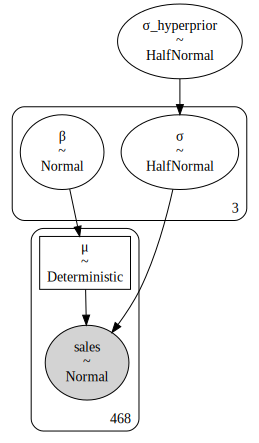

In [145]:
with pm.Model(
    coords={"food_category": food_category.categories}
) as model_hierarchical_sales:
    σ_hyperprior = pm.HalfNormal("σ_hyperprior", sigma=20)
    σ = pm.HalfNormal("σ", sigma=σ_hyperprior, dims="food_category")

    β = pm.Normal("β", mu=10, sigma=20, dims="food_category")
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)

    sales = pm.Normal(
        "sales", mu=μ, sigma=σ[food_category.codes], observed=sales_observed
    )

    trace_hierarchical_sales = pm.sample(target_accept=0.9, return_inferencedata=False)
    inf_data_hierarchical_sales = az.from_pymc3(
        trace=trace_hierarchical_sales,
        coords={
            "β_dim_0": food_category.categories,
            "σ_dim_0": food_category.categories,
        },
    )

pm.model_to_graphviz(model_hierarchical_sales)

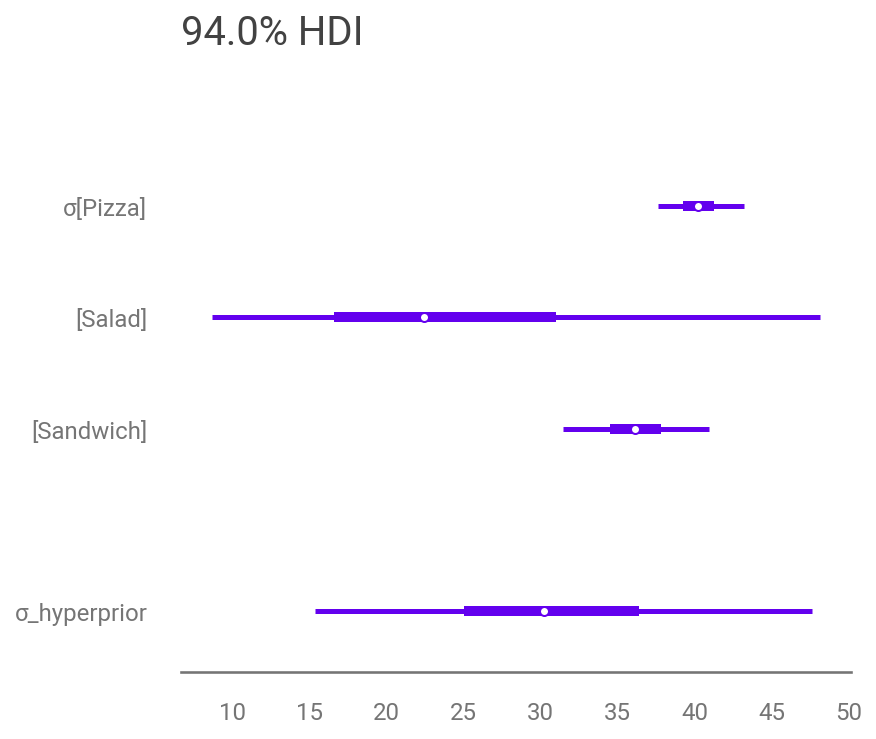

In [146]:
az.plot_forest(
    inf_data_hierarchical_sales,
    var_names=["σ", "σ_hyperprior"],
    combined=True,
);

In [149]:
(
    az.summary(inf_data_sales_unpooled.posterior["σ"], kind="stats").rename_axis(
        "Unpooled σ"
    )
)

,mean,sd,hdi_3%,hdi_97%
Unpooled σ,,,,
σ[Pizza],40.152,1.482,37.381,42.863
σ[Salad],21.187,8.249,8.428,36.176
σ[Sandwich],35.884,2.486,31.287,40.342


In [152]:
(
    az.summary(
        inf_data_hierarchical_sales, var_names=["σ", "σ_hyperprior"], kind="stats"
    ).rename_axis("Hierarchical σ")
)

,mean,sd,hdi_3%,hdi_97%
Hierarchical σ,,,,
σ[Pizza],40.270,1.505,37.639,43.166
σ[Salad],25.518,12.925,8.673,48.154
σ[Sandwich],36.220,2.528,31.436,40.939
σ_hyperprior,31.527,8.987,15.374,47.627


In unpooled salad $\sigma$ is 21
while for hierarchical it's ~26.
It has been pulled up by the pizza $\sigma$.
Hierarcical $\sigma$ values for both pizza and sandwhich are similar to those of the unpooled.

You can also use hyperpriors for $\beta$,
and have one hyperprior for each hyperparameter.

Could also do something like a three-level hierarchical model.
Where top level is company,
next is geographical market,
and lowerst is individual location.

### Posterior geometry matters

Some posterior geometries
are challengeing for samplers—like
Niel's funnel.

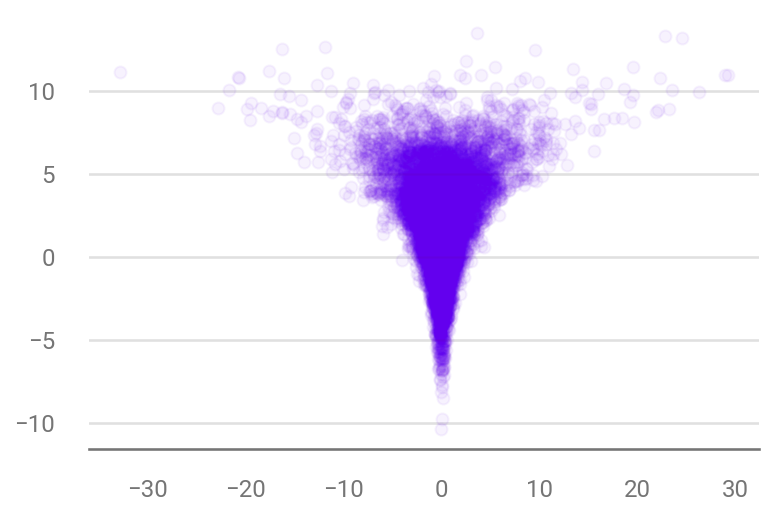

In [154]:
n_sample = 10_000
yr = stats.norm.rvs(loc=2.0, scale=3.0, size=n_sample)
xnr = stats.norm.rvs(loc=0.0, scale=np.exp(yr / 4), size=(1, n_sample))

_, ax = plt.subplots()
ax.scatter(xnr[0], yr, alpha=0.05);

In complex shapes,
it's hard to figure out the proper step size.
Niel's funnel is wide and sparse on top,
dense and narrow on bottom.

In hierarchical models
the geometry is largely defined by the correlation of hyperpriors to other parameters—which
can result in funnel geometry that are difficult to sample.

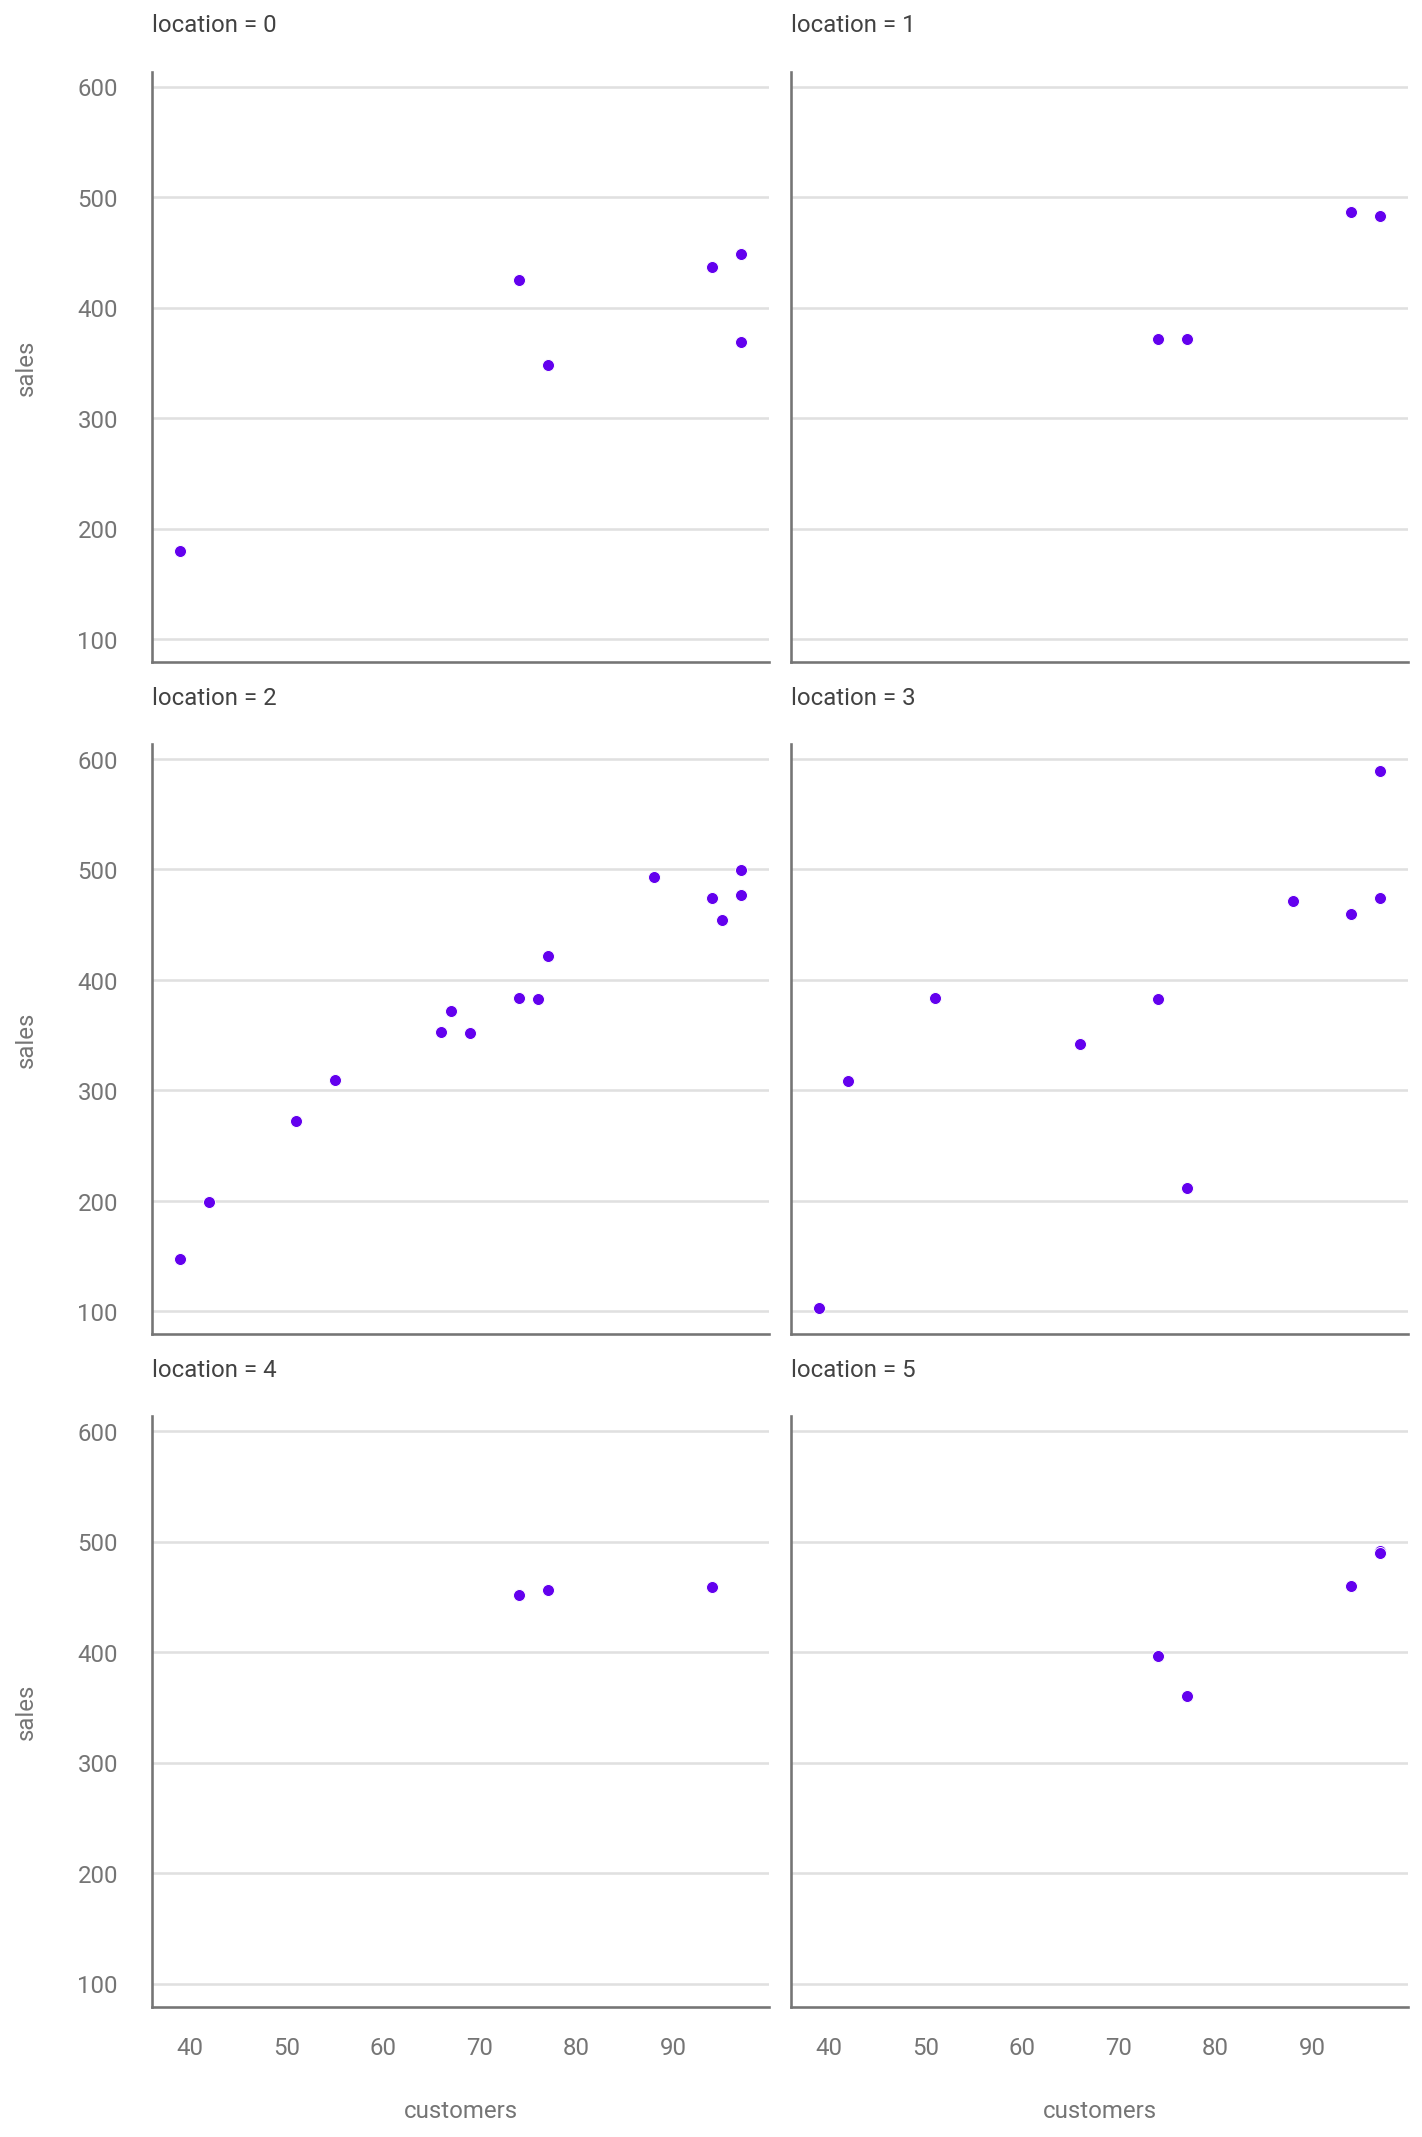

In [159]:
def salad_generator(
    hyperprior_beta_mean=5,
    hyperprior_beta_sigma=0.2,
    sigma=50,
    days_per_location=[6, 4, 15, 10, 3, 5],
    sigma_per_location=[50, 10, 20, 80, 30, 20],
) -> DataFrame:
    """Generate noisy salad data"""
    beta_hyperprior = stats.norm(hyperprior_beta_mean, hyperprior_beta_sigma)

    # Generate demands days per restaurant
    df = pd.DataFrame()
    for i, days in enumerate(days_per_location):
        np.random.seed(0)

        num_customers = stats.randint(30, 100).rvs(days)
        sales_location = beta_hyperprior.rvs() * num_customers + stats.norm(
            0, sigma_per_location[i]
        ).rvs(num_customers.shape)

        location_df = pd.DataFrame(
            {"customers": num_customers, "sales": sales_location}
        )
        location_df["location"] = i
        location_df.sort_values(by="customers", ascending=True)
        df = pd.concat([df, location_df])

    df.reset_index(inplace=True, drop=True)
    return df


hierarchical_salad_df = salad_generator()
(
    hierarchical_salad_df.pipe(
        (sns.relplot, "data"), x="customers", y="sales", col="location", col_wrap=2
    )
);

$$
\begin{split}
\beta_{\mu h} \sim& \mathcal{N} \\
\beta_{\sigma h} \sim& \mathcal{HN} \\
\beta_m \sim& \overbrace{\mathcal{N}(\beta_{\mu h},\beta_{\sigma h})}^{\text{Centered}}  \\
\sigma_{h} \sim& \mathcal{HN} \\
\sigma_{m} \sim& \mathcal{HN}(\sigma_{h}) \\
Y \sim& \mathcal{N}(\beta_{m} * X_m,\sigma_{m})
\end{split}
$$

In [164]:
root = tfd.JointDistributionCoroutine.Root
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts, autograph=False, jit_compile=True
)


def gen_hierarchical_salad_sales(input_df, beta_prior_fn, dtype=tf.float32):
    customers = tf.constant(input_df["customers"].to_numpy(), dtype=dtype)
    location_category = input_df["location"].to_numpy()
    sales = tf.constant(input_df["sales"].to_numpy(), dtype=dtype)

    @tfd.JointDistributionCoroutine
    def model_hierarchical_salad_sales():
        β_μ_hyperprior = yield root(tfd.Normal(0, 10, name="beta_mu"))
        β_σ_hyperprior = yield root(tfd.HalfNormal(0.1, name="beta_sigma"))
        β = yield from beta_prior_fn(β_μ_hyperprior, β_σ_hyperprior)

        σ_hyperprior = yield root(tfd.HalfNormal(30, name="sigma_prior"))
        σ = yield tfd.Sample(tfd.HalfNormal(σ_hyperprior), 6, name="sigma")

        loc = tf.gather(β, location_category, axis=-1) * customers
        scale = tf.gather(σ, location_category, axis=-1)
        sales = yield tfd.Independent(
            tfd.Normal(loc, scale), reinterpreted_batch_ndims=1, name="sales"
        )

    return model_hierarchical_salad_sales, sales


def centered_beta_prior_fn(hyper_mu, hyper_sigma):
    """A centered β prior."""
    β = yield tfd.Sample(tfd.Normal(hyper_mu, hyper_sigma), 6, name="beta")
    return β


centered_model, observed = gen_hierarchical_salad_sales(
    hierarchical_salad_df, centered_beta_prior_fn
)
mcmc_samples_centered, sampler_stats_centered = run_mcmc(
    1000,
    centered_model,
    n_chains=4,
    num_adaptation_steps=1000,
    sales=observed,
)

divergent_per_chain = np.sum(sampler_stats_centered["diverging"], axis=0)
divergent_per_chain

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-05-21 16:38:15.090772: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7ff5a9a41130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-21 16:38:15.090794: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-05-21 16:38:15.498114: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-05-21 16:38:15.614936: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2022-05-21 16:38:15.824076: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
2022-05-21 16:38:32.790974: I tensorflow/compiler/jit/xla_compila

array([ 26,  46, 109,  35])

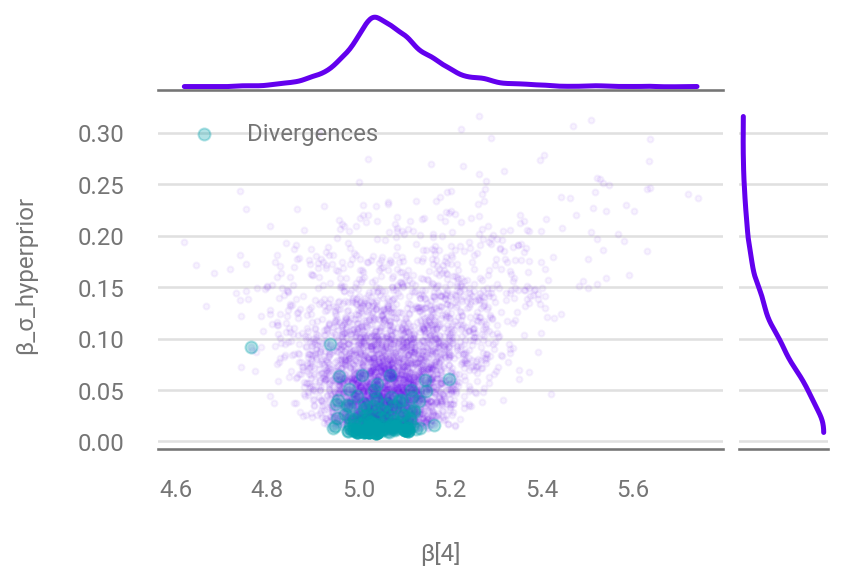

In [188]:
slope = mcmc_samples_centered.beta[..., 4].numpy().flatten()
sigma = mcmc_samples_centered.beta_sigma.numpy().flatten()
divergences = sampler_stats_centered["diverging"].numpy().flatten()
axes = az.plot_pair(
    {
        "β[4]": slope,
        "β_σ_hyperprior": sigma,
    },
    marginals=True,
    scatter_kwargs={"alpha": 0.05},
)
axes[1][0].scatter(
    slope[divergences],
    sigma[divergences],
    color="C1",
    alpha=0.3,
    label="Divergences",
)
axes[1][0].legend();

As $\beta_{\sigma h}$ approaches 0,
the width of the posterior estimate of $\beta_m$ shrinks
and the sampler is not able to effectively characterize the posterior space.

This can be alleviated
by converting into a non-centered parameterization.
Instead of estimating parameters of the slope $\beta_m$ directly,
we can model a common term shared between all groups
and a term for each group
that caputres the deviation
from the common term.

$$
\begin{split}
\beta_{\mu h} \sim& \mathcal{N} \\
\beta_{\sigma h} \sim& \mathcal{HN} \\
\beta_\text{m_offset} \sim& \mathcal{N}(0,1) \\
\beta_m =& \overbrace{\beta_{\mu h} + \beta_\text{m_offset}*\beta_{\sigma h}}^{\text{Non-centered}}  \\
\sigma_{h} \sim& \mathcal{HN} \\
\sigma_{m} \sim& \mathcal{HN}(\sigma_{h}) \\
Y \sim& \mathcal{N}(\beta_{m} * X_m,\sigma_{m})
\end{split}
$$

In [189]:
def non_centered_beta_prior_fn(hyper_mu, hyper_sigma):
    """A non-centered prior for β."""
    β_offset = yield root(tfd.Sample(tfd.Normal(0, 1), 6, name="beta_offset"))
    return β_offset * hyper_sigma[..., None] + hyper_mu[..., None]


non_centered_model, observed = gen_hierarchical_salad_sales(
    hierarchical_salad_df, non_centered_beta_prior_fn
)
mcmc_samples_noncentered, sampler_stats_noncentered = run_mcmc(
    1_000,
    non_centered_model,
    n_chains=4,
    num_adaptation_steps=1_000,
    sales=observed,
)

divergent_per_chain = np.sum(sampler_stats_noncentered["diverging"], axis=0)
divergent_per_chain

2022-05-21 19:09:35.869404: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


array([0, 2, 1, 0])

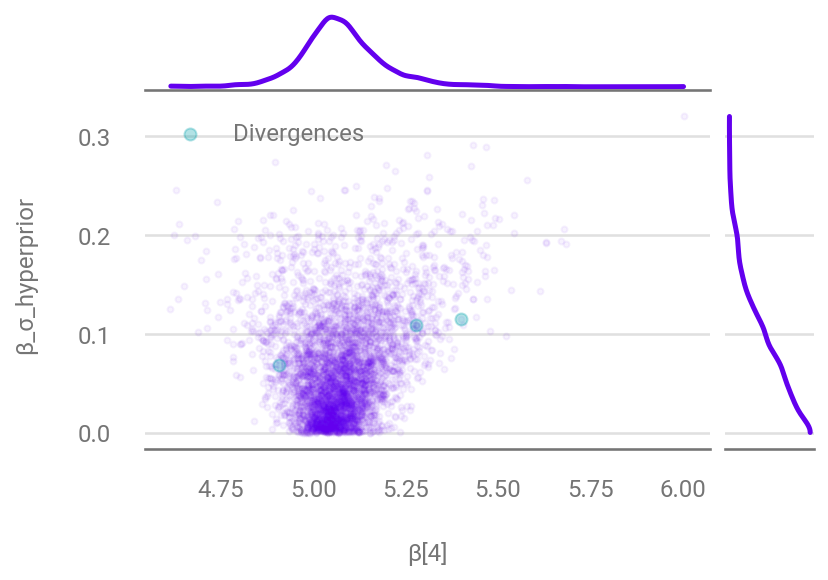

In [190]:
noncentered_beta = (
    mcmc_samples_noncentered.beta_mu[..., None]
    + mcmc_samples_noncentered.beta_offset
    * mcmc_samples_noncentered.beta_sigma[..., None]
)
slope = noncentered_beta[..., 4].numpy().flatten()
sigma = mcmc_samples_noncentered.beta_sigma.numpy().flatten()
divergences = sampler_stats_noncentered["diverging"].numpy().flatten()
axes = az.plot_pair(
    {
        "β[4]": slope,
        "β_σ_hyperprior": sigma,
    },
    marginals=True,
    scatter_kwargs={"alpha": 0.05},
)
axes[1][0].scatter(
    slope[divergences],
    sigma[divergences],
    color="C1",
    alpha=0.3,
    label="Divergences",
)
axes[1][0].legend();

The posterior geometry is now modified
in a way that allows the sampler to more easily explore all possible values of $\beta_{\sigma h}$.

In general,
if there are not a lot of observations,
a non-centered parameterization is preferred.

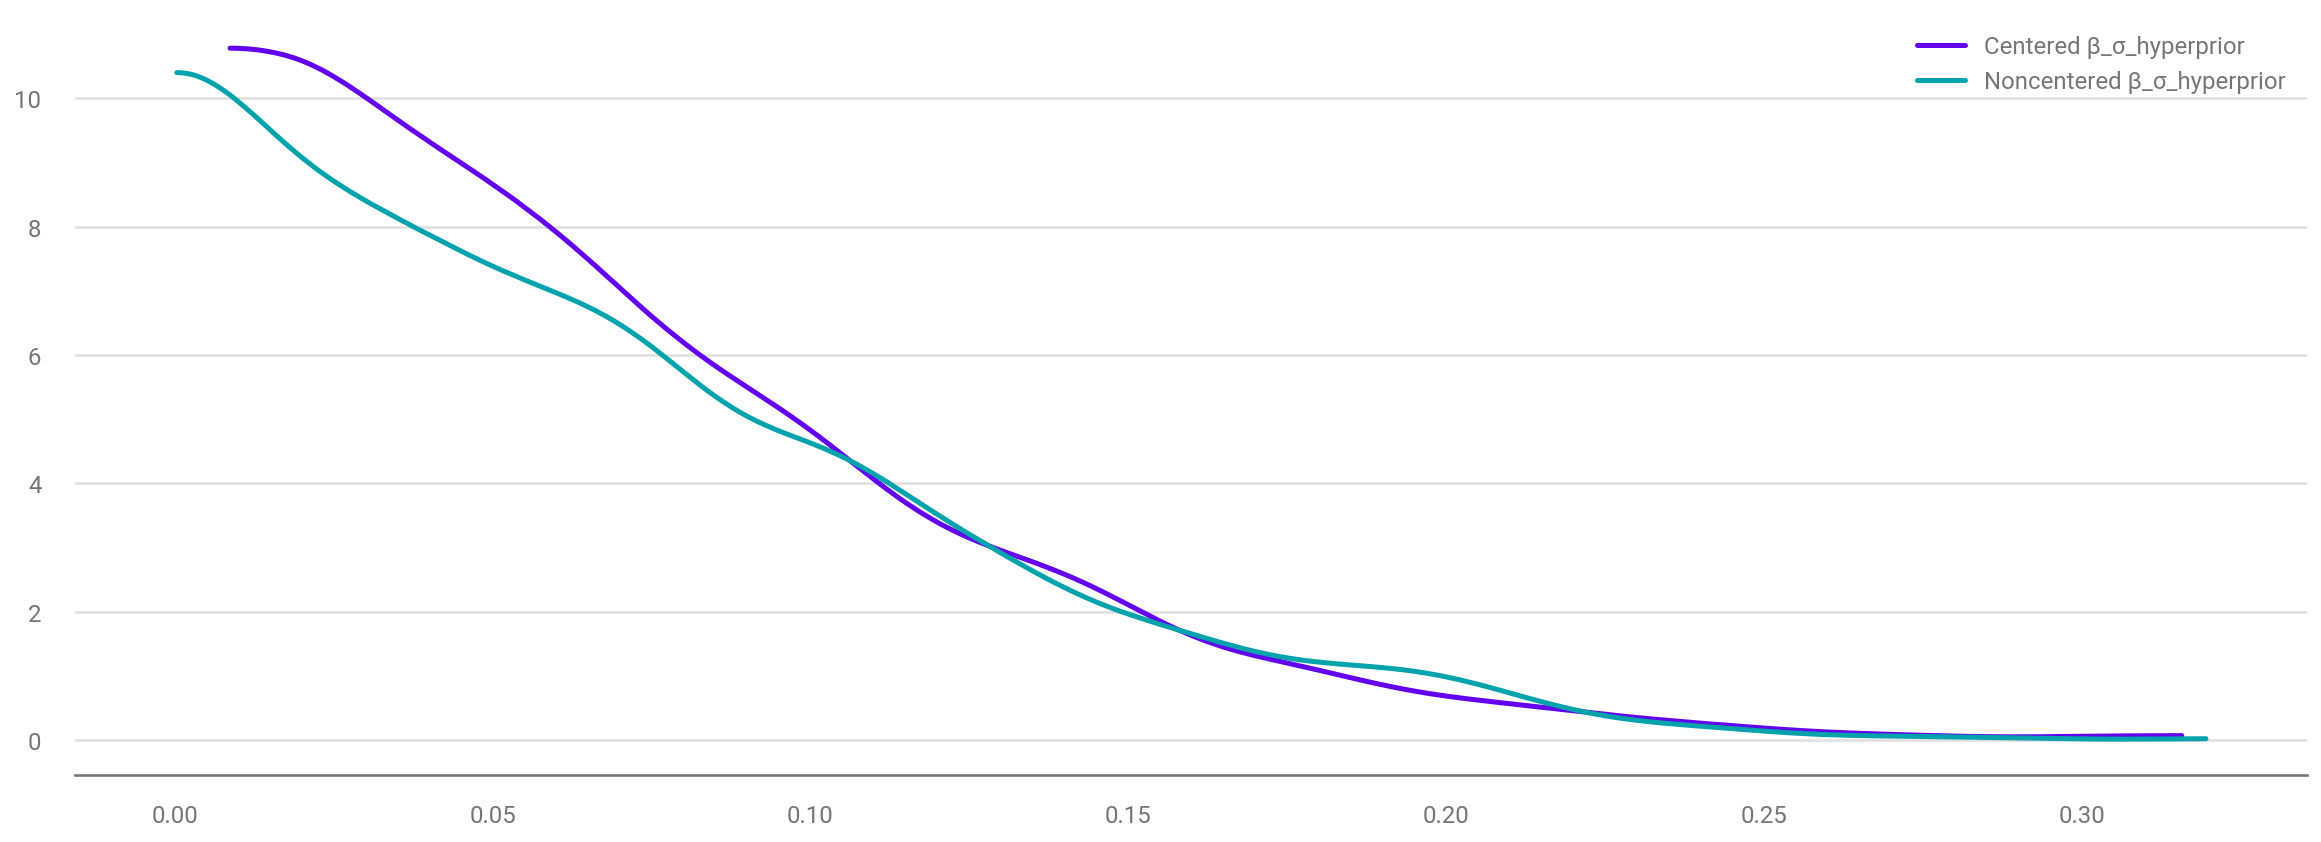

In [195]:
_, ax = plt.subplots(figsize=(20, 7))
centered_β_sigma = mcmc_samples_centered.beta_sigma.numpy()
noncentered_β_sigma = mcmc_samples_noncentered.beta_sigma.numpy()
az.plot_kde(centered_β_sigma, label="Centered β_σ_hyperprior", ax=ax)
az.plot_kde(
    noncentered_β_sigma,
    label="Noncentered β_σ_hyperprior",
    ax=ax,
    plot_kwargs={"color": "C1"},
);

### Predictions at multiple levels

Can simultaneously make predicitons
for two different locations
and the company as a whole.

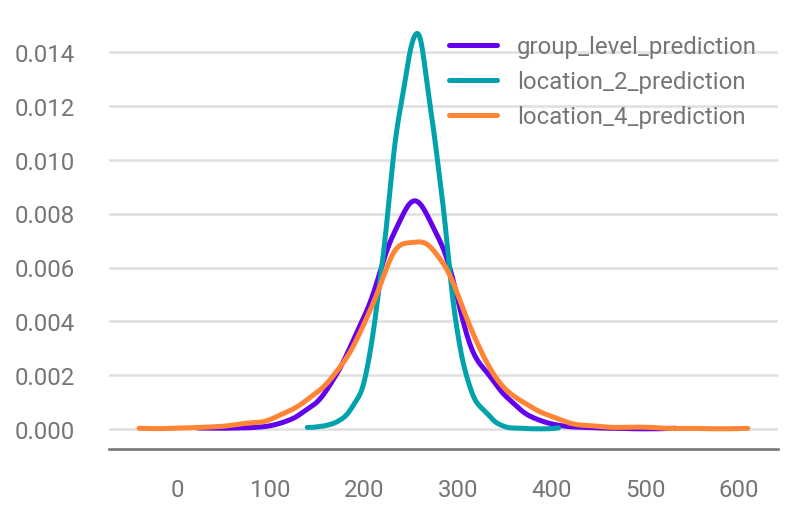

In [205]:
out_of_sample_customers = 50.0


@tfd.JointDistributionCoroutine
def out_of_sample_prediction_model():
    model = yield root(non_centered_model)
    β = model.beta_offset * model.beta_sigma[..., None] + model.beta_mu[..., None]

    β_group = yield tfd.Normal(
        model.beta_mu, model.beta_sigma, name="group_beta_prediction"
    )
    group_level_prediction = yield tfd.Normal(
        β_group * out_of_sample_customers,
        model.sigma_prior,
        name="group_level_prediction",
    )
    for l in [2, 4]:
        yield tfd.Normal(
            tf.gather(β, l, axis=-1) * out_of_sample_customers,
            tf.gather(model.sigma, l, axis=-1),
            name=f"location_{l}_prediction",
        )


amended_posterior = tf.nest.pack_sequence_as(
    non_centered_model.sample(), list(mcmc_samples_noncentered) + [observed]
)

ppc = out_of_sample_prediction_model.sample(var0=amended_posterior)

_, ax = plt.subplots()
for idx, prediction_group in enumerate(
    [
        "group_level_prediction",
        "location_2_prediction",
        "location_4_prediction",
    ]
):
    az.plot_kde(
        getattr(ppc, prediction_group).numpy(),
        plot_kwargs={"color": f"C{idx}"},
        ax=ax,
        label=prediction_group,
    )

Can also make predictions
for never before seen groups
by sampling from hyper priors to get $\beta$ and $\sigma$ of new location.

In [206]:
out_of_sample_customers2 = np.arange(50, 90)


@tfd.JointDistributionCoroutine
def out_of_sample_prediction_model2():
    model = yield root(non_centered_model)

    β_new_loc = yield tfd.Normal(model.beta_mu, model.beta_sigma, name="beta_new_loc")
    σ_new_loc = yield tfd.HalfNormal(model.sigma_prior, name="sigma_new_loc")
    group_level_prediction = yield tfd.Normal(
        β_new_loc[..., None] * out_of_sample_customers2,
        σ_new_loc[..., None],
        name="new_location_prediction",
    )


ppc = out_of_sample_prediction_model2.sample(var0=amended_posterior)

Can use LOO to assess how well a model is able to predict new observations,
but not if we want to asses how well an entire group is predicted.
Can use leave one-group-out cross validation for that.
This is because we are removing many observations at a time,
and the importance sampling step for LOO assumes
the distribtutions with and without the groups or point being similar.

### Priors for multilevel models

Hypepriors depends both on the number of groups you have
and the number of observations in each groups.
We can perform sensitivity studies to inform our prior choice.